### Explain about DnCNN

It takes a noisy image as input and outputs a residual image that represents the noise. The clean image can be obtained by subtracting the residual image from the noisy image. The network is trained on synthetic images with additive white Gaussian noise (AWGN) and can handle different noise levels with a single model. The network uses residual learning and batch normalization to speed up the training process and improve the denoising performance.

The main steps of DnCNN are:

*   Preprocessing: The input noisy image is normalized to [0, 1] range, and then cropped into patches of size 40x40.
*   Denoising: The denoising subnetwork is composed of 17 convolutional layers with 3x3 kernels and 64 filters, except for the first and the last layers which have 1 filter. The first layer is followed by a ReLU activation function, and the other layers are followed by a batch normalization layer and a ReLU activation function. The network learns to estimate the residual image from the noisy image, using mean squared error (MSE) loss as the objective function.
*  	Postprocessing: The output residual image is denormalized to [0, 255] range, and then subtracted from the input noisy image to obtain the clean image.


### Requirment

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Libraries

In [ ]:
import opendatasets as od
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import numpy as np 
import pandas as pd 
import os
import skimage.io as skio
import torchvision.utils as utils
import math
import torch.nn as nn
import os.path
import random
import h5py
import torch
import cv2
import glob
import torch.utils.data as udata
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
from tqdm.contrib import tenumerate
from torch.utils.data import Dataset
from torchsummary import summary
from skimage.metrics import peak_signal_noise_ratio


### Loading Dataset

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import opendatasets as od
#{"username":"zahrasorkhei","key":"0548e34bf61c0f9a1661511e47b029e6"}
od.download(
    "https://www.kaggle.com/datasets/kmader/siim-medical-images/download?datasetVersionNumber=6")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: zahrasorkhei
Your Kaggle Key: ··········


100%|██████████| 250M/250M [00:02<00:00, 100MB/s]


### Create dataloader and adding noise 

In [ ]:
class MyDataset(Dataset):
    def __init__(self, train = True,percent=80):

        data  = pd.read_csv('/content/siim-medical-images/overview.csv')
        if train == True:
            self.files_name = data.tiff_name.values[:percent]
        elif train == False:
            self.files_name = data.tiff_name.values[percent:]

    
    def __len__(self):
        return len(self.files_name)
    
    def __getitem__(self, index):
        im = skio.imread('/content/siim-medical-images/tiff_images/' + self.files_name[index])
        im = im.reshape((1, 512, 512))
        im = np.array(im)
        im = np.interp(im, (im.min(), im.max()), (0, 1))
        # adding noise and clip between 0 and 1

        noise = np.random.normal(0, .1, im.shape)
        noisy_im = im + noise
        noisy_im = np.clip(noisy_im, 0, 1)

        return torch.tensor(noisy_im, dtype=torch.float32) , torch.tensor(im, dtype=torch.float32)

In [ ]:
dataset_train = MyDataset(train=True)
dataset_test = MyDataset(train=False)
loader_train = DataLoader(dataset=dataset_train, num_workers=4, batch_size=10, shuffle=True)
loader_test = DataLoader(dataset=dataset_test, num_workers=4, batch_size=10, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Net

In [ ]:
class DnCNN(nn.Module):
    def __init__(self, channels=1, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
    def forward(self, x):
        out = self.dncnn(x)
        return out

### Training 

In [ ]:
def train_model(model, epochs, criterion, optimizer, train_loader, test_loader):
  # Initialize the lists to store the losses
  train_losses = []
  test_losses = []
  best_model_loss = np.inf
  best_model = []

  # Loop over the number of epochs
  for epoch in range(epochs):
    # Initialize the running loss for this epoch
    train_loss = 0.0

    # Loop over the training data
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      # Forward pass
      outputs = model(inputs)
      # Compute the loss
      loss = criterion(outputs, labels)
      # Backward pass and optimize
      loss.backward()
      optimizer.step()
      # Zero the parameter gradients
      optimizer.zero_grad()
      # Update the running loss
      train_loss += loss.item()

    # Compute the average train loss for this epoch
    train_loss = train_loss / len(train_loader)
    # Append it to the list of train losses
    train_losses.append(train_loss)

    # Set the model to evaluation mode
    model.eval()
    # Initialize the running loss for this epoch
    test_loss = 0.0

    # Loop over the test data
    with torch.no_grad():
      for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        # Compute the loss
        loss = criterion(outputs, labels)
        # Update the running loss
        test_loss += loss.item()

    # Compute the average test loss for this epoch
    test_loss = test_loss / len(test_loader)
    # Append it to the list of test losses
    test_losses.append(test_loss)
    if(test_loss<best_model_loss):
      best_model_loss = test_loss
      best_model = model

    # Print the train and test losses for this epoch
    print(f'=========================== Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

  # Return the model and the lists of losses
  return best_model, train_losses, test_losses



In [13]:
model = DnCNN(num_of_layers=7).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
summary(model, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             576
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,864
       BatchNorm2d-4         [-1, 64, 512, 512]             128
              ReLU-5         [-1, 64, 512, 512]               0
            Conv2d-6         [-1, 64, 512, 512]          36,864
       BatchNorm2d-7         [-1, 64, 512, 512]             128
              ReLU-8         [-1, 64, 512, 512]               0
            Conv2d-9         [-1, 64, 512, 512]          36,864
      BatchNorm2d-10         [-1, 64, 512, 512]             128
             ReLU-11         [-1, 64, 512, 512]               0
           Conv2d-12         [-1, 64, 512, 512]          36,864
      BatchNorm2d-13         [-1, 64, 512, 512]             128
             ReLU-14         [-1, 64, 5

In [15]:
num_epoch = 20
best_model, train_losses, test_losses = train_model(model, num_epoch, criterion, optimizer, loader_train, loader_test)

=========================== Epoch 1, Train Loss: 0.1688, Test Loss: 0.0832
=========================== Epoch 2, Train Loss: 0.0387, Test Loss: 0.0090
=========================== Epoch 3, Train Loss: 0.0072, Test Loss: 0.0081
=========================== Epoch 4, Train Loss: 0.0053, Test Loss: 0.0026
=========================== Epoch 5, Train Loss: 0.0028, Test Loss: 0.0025
=========================== Epoch 6, Train Loss: 0.0016, Test Loss: 0.0017
=========================== Epoch 7, Train Loss: 0.0013, Test Loss: 0.0016
=========================== Epoch 8, Train Loss: 0.0011, Test Loss: 0.0013
=========================== Epoch 9, Train Loss: 0.0010, Test Loss: 0.0012
=========================== Epoch 10, Train Loss: 0.0009, Test Loss: 0.0012
=========================== Epoch 11, Train Loss: 0.0009, Test Loss: 0.0011
=========================== Epoch 12, Train Loss: 0.0009, Test Loss: 0.0011
=========================== Epoch 13, Train Loss: 0.0009, Test Loss: 0.0011
=====================

### Testing

In [16]:
def test_model(model, test_loader, criterion):
  # Set the model to evaluation mode
  model.eval()
  # Initialize the running loss and the list of outputs
  test_loss = 0.0
  outputs_list = []

  # Loop over the test data
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      # Forward pass
      outputs = model(inputs)
      # Compute the loss
      loss = criterion(outputs, labels)
      # Update the running loss
      test_loss += loss.item()
      # Append the outputs to the list
      outputs_list.append(outputs)

  # Compute the average test loss
  test_loss = test_loss / len(test_loader)
  # Concatenate the outputs into a tensor
  outputs_tensor = torch.cat(outputs_list, dim=0)
  print(f'Average Test Loss: {test_loss:.4f}')

  # Return the average loss and the outputs tensor
  return test_loss, outputs_tensor



In [18]:
test_loss,prediction = test_model(best_model, loader_test, criterion)

Average Test Loss: 0.0010


In [19]:
def rmse(x, y):
    return torch.sqrt(torch.mean((x - y) ** 2))
def psnr_cal(x, y, data_range=1):
    return 20 * torch.log10(data_range / rmse(x, y))

def show_images(image,distorted,reconstruction,title):
      plt.figure(figsize=(10, 4))
      plt.subplot(1, 3, 1)
      plt.title("Original Image")
      plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
      plt.xticks(())
      plt.yticks(())
      plt.subplot(1, 3, 2)
      psnr = psnr_cal(image, distorted)
      plt.title("Noisy Image , PSNR: %.2f" % psnr)
      plt.imshow(distorted, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
      plt.xticks(())
      plt.yticks(())
      plt.subplot(1, 3, 3)
      plt.title("Reconstructed Image")
      psnr = psnr_cal(image, reconstruction)
      plt.title("PSNR: %.2f" % psnr)
      plt.imshow(reconstruction, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
      plt.xticks(())
      plt.yticks(())
      plt.suptitle(title, size=16)
      plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

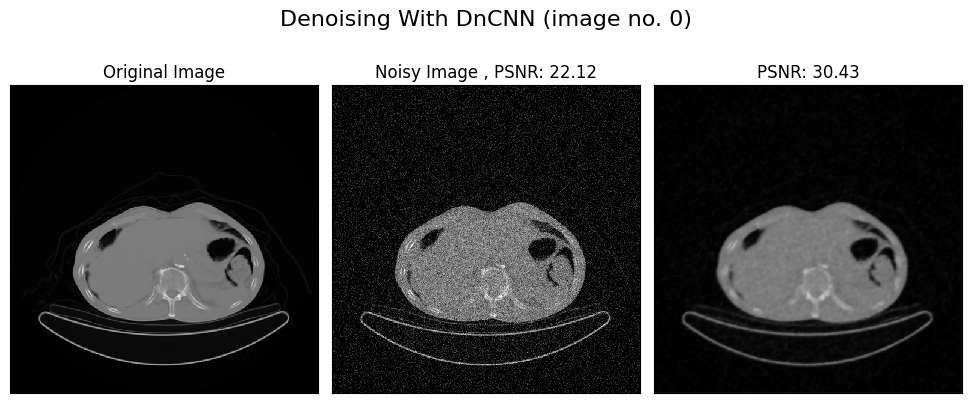

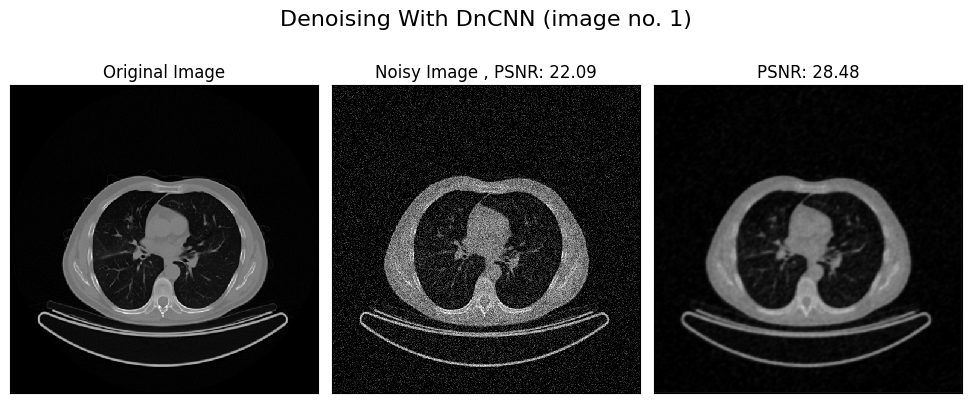

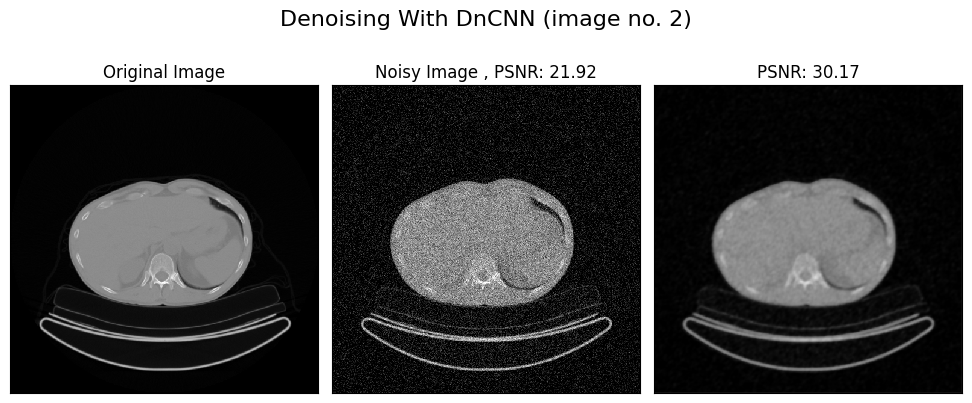

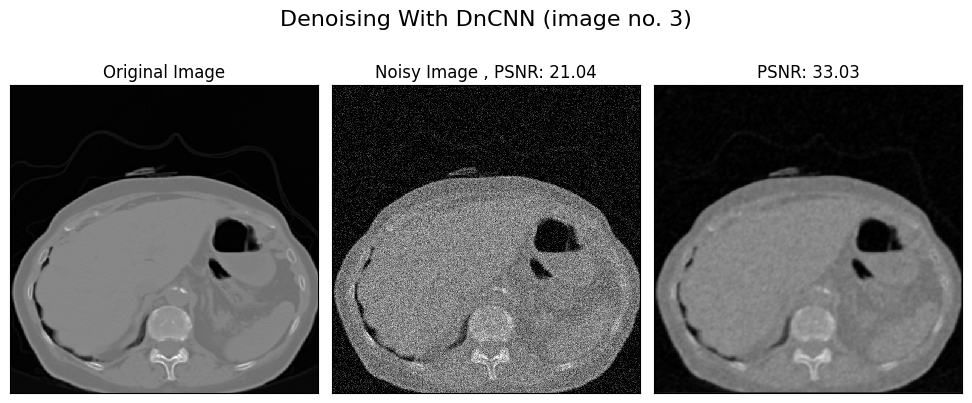

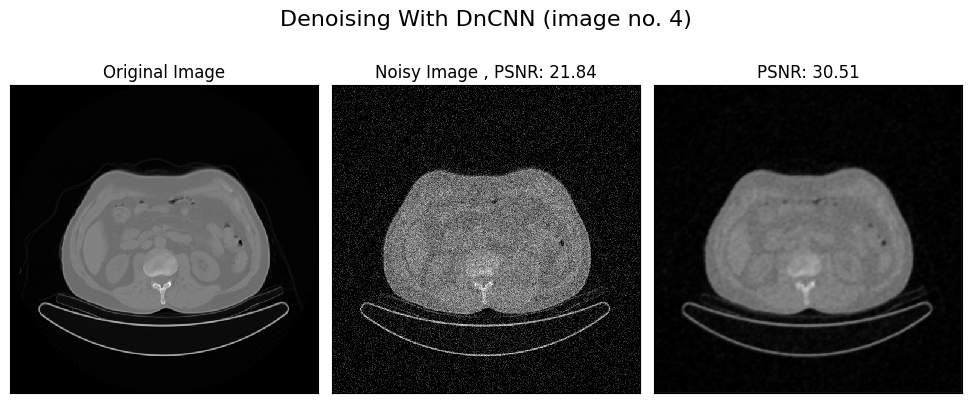

In [20]:
n = 5
for i, (image, distorted) in enumerate(dataset_test ):
    reconstruction = prediction[i].to('cpu')
    show_images(distorted[0],image[0],reconstruction[0],"Denoising With DnCNN"+ " (image no. %d)" % i)
    if i == n-1:
        break
plt.show()